In [18]:
import plotly
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
import matplotlib.animation as animation
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.lines import Line2D
from scipy.signal import fftconvolve
from sklearn.svm import LinearSVC
from itertools import *
from joblib import Parallel, delayed


In [19]:

!git clone https://github.com/HNinou/MathTools_TD2
!unzip MathTools_TD2/dic_cont8_GO.npy.zip -d MathTools_TD2/

fatal: destination path 'MathTools_TD2' already exists and is not an empty directory.
Archive:  MathTools_TD2/dic_cont8_GO.npy.zip
replace MathTools_TD2/dic_cont8_GO.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: MathTools_TD2/dic_cont8_GO.npy  
  inflating: MathTools_TD2/__MACOSX/._dic_cont8_GO.npy  


The cell below generates the data and stores it in the matrix X

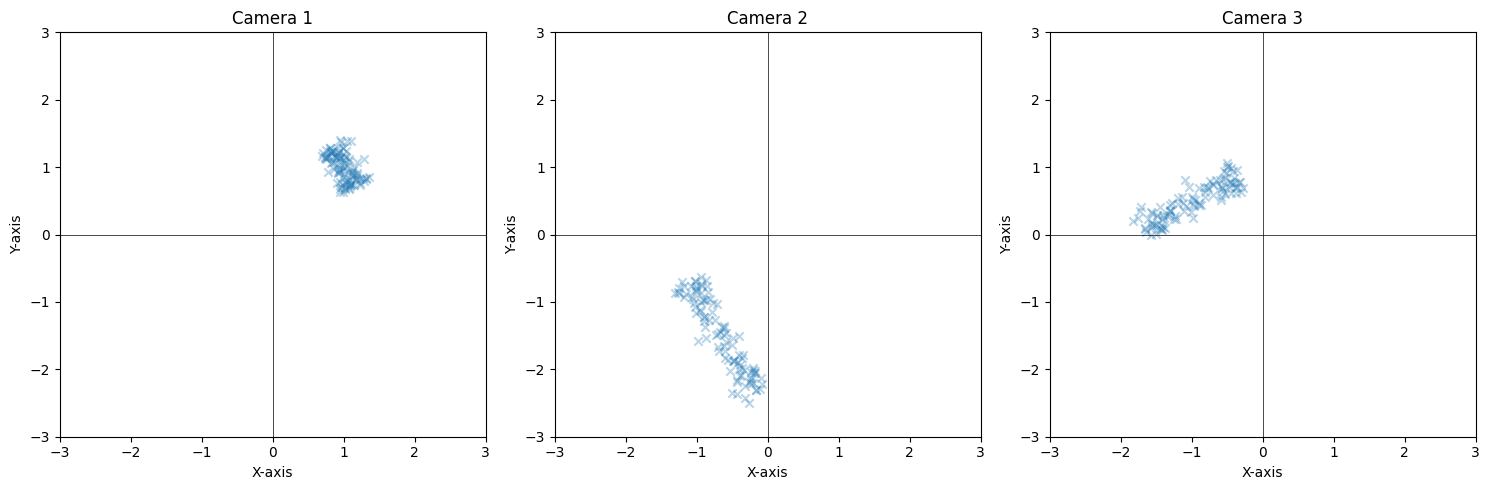

In [20]:
def generate_spring_data(nb_timesteps, noise_level):
    nb_timesteps = int(nb_timesteps)

    x = np.cos(np.linspace(0, np.pi, num = nb_timesteps))
    y = np.zeros(nb_timesteps)

    x += np.random.normal(0, noise_level, size = nb_timesteps)
    y += np.random.normal(0, noise_level, size = nb_timesteps)

    return (x,y)

def rotate_data(x,y, theta, phi):
    return (x*np.cos(phi)*np.cos(theta)+y*np.sin(theta), -x*np.cos(phi)*np.sin(theta)+y*np.cos(theta))


nb_timesteps=int(1e2)
noise_level=0.1
x_ini,y_ini = generate_spring_data(nb_timesteps, noise_level)

X = np.zeros((6,int(nb_timesteps)))

theta1 = np.pi/3
phi1 = 2*np.pi/5

theta2 = -2*np.pi/3
phi2 = np.pi/6

theta3 = -np.pi/6
phi3 = -np.pi/4

angle_list =  [(theta1,phi1), (theta2,phi2), (theta3,phi3)]
offset_list = [(1,1),(-2/3,-3/2),(-1,1/2)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (theta, phi) in enumerate(angle_list):
    # Get the current subplot
    ax = axes[i]

    # Calculate rotated data
    x = rotate_data(x_ini, y_ini, theta, phi)[0] + offset_list[i][0]
    X[i] = x
    y = rotate_data(x_ini, y_ini, theta, phi)[1] + offset_list[i][1]
    X[i+3] = y

    # Plot on the current subplot
    ax.scatter(x, y, marker='x', alpha=0.3)

    # Set axis limits and labels
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_title(f"Camera {i + 1}")
    ax.axhline(0, color='black', linewidth=0.5)  # Horizontal axis at y=0
    ax.axvline(0, color='black', linewidth=0.5)  # Vertical axis at x=0


# Display the plots
plt.tight_layout()
plt.show()

# Exercice 1
## 1)
What is the intrinsic dimensionality of the mass’ position ?

 **1**

 What is the dimensionality of the data stored in X ?

 **6**

 ## 2)

 What kind of basis results from implementing a PCA ?

orthogonal basis (eigenbasis), that maximises the projected variance.  (vectors of new basis have dimension 6, are orthornormal)


## 3)
What is the covariance matrix C of our data ? What size is it ?

C = 1/T XX.T   (T is timesteps =100)

 we have 6 measurments so the size of C is number of measurements * number of measurements = 6*6 = 36

## 4)

In [21]:
C = (X@X.T)/nb_timesteps
eigval, eigvec = np.linalg.eigh(C)

## 5)

Text(0.5, 1.0, 'Eigenvalues')

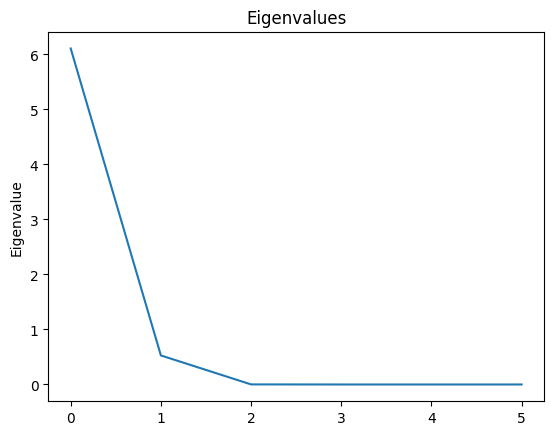

In [22]:
plt.plot(eigval[::-1])
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues')

Text(0, 0.5, 'PC2')

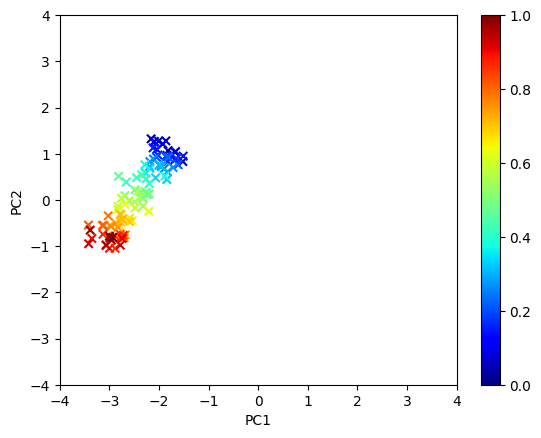

In [23]:
PC1 = eigvec[:,-1]
PC2 = eigvec[:,-2]

plt.scatter(PC1@X, PC2@X, marker = 'x', cmap = 'jet', c=np.linspace(0,1, num =nb_timesteps))
plt.colorbar()
plt.ylim((-4,4))
plt.xlim((-4,4))
plt.xlabel('PC1')
plt.ylabel('PC2')

What is the problem here ?


The data is not centered and skewed.

If the data is not mean-centered, the covariance matrix includes the effects of the mean. PCs biased toward the mean of the data rather than capturing the true directions of maximal variance

(the data is not mean-centered and it is a problem because PCA assumes that the data is centered at the origin (mean of zero for each feature)).


## 6)

In [24]:
X_centered = X - X.mean(axis=1)[:,None]
C_c = (X_centered@X_centered.T)/nb_timesteps
eigval_c, eigvec_c = np.linalg.eigh(C_c)

Text(0.5, 1.0, 'Eigenvalues')

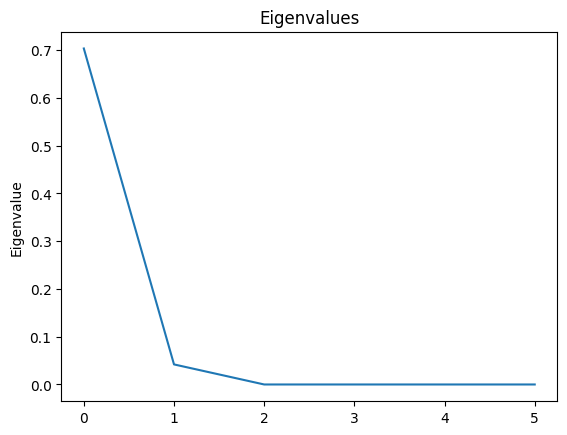

In [25]:
plt.plot(eigval_c[::-1])
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues')

Text(0, 0.5, 'PC2')

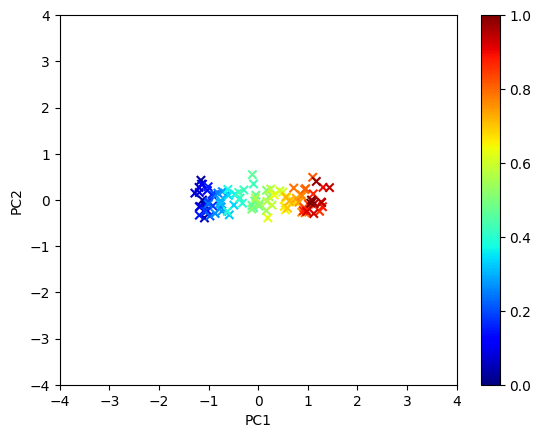

In [26]:
PC1_c = eigvec_c[:,-1]
PC2_c  = eigvec_c[:,-2]

plt.scatter(PC1_c@X_centered, PC2_c@X_centered, marker = 'x', cmap = 'jet', c=np.linspace(0,1, num =nb_timesteps))
plt.colorbar()
plt.ylim((-4,4))
plt.xlim((-4,4))
plt.xlabel('PC1')
plt.ylabel('PC2')

## 7) the variance of the data projected on the first PC with the first eigenvalue of the correct correlation matrix **are the same**

In [27]:
print(np.var(PC1_c@X_centered), eigval_c[-1])

0.7036516296507762 0.703651629650776


## 8) the variance of the data projected on the second PC with the second eigenvalue of the correct correlation matrix **are the same**

In [28]:
print(np.var(PC2_c@X_centered), eigval_c[-2])

0.0420293254570264 0.042029325457026444


## 9)


In [29]:
U,S,Vh = np.linalg.svd(X_centered, full_matrices = False)

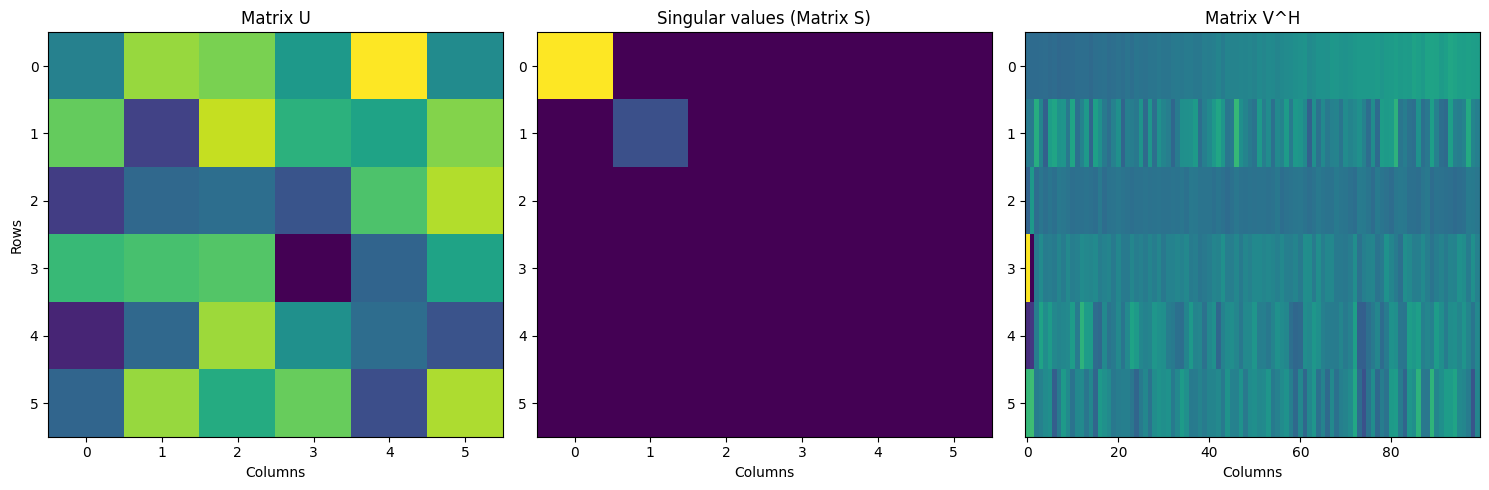

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display matrix U
axes[0].imshow(U, cmap='viridis', aspect='auto')
axes[0].set_title("Matrix U")
axes[0].set_xlabel("Columns")
axes[0].set_ylabel("Rows")

# Display singular values as a diagonal matrix S
S_matrix = np.diag(S)
axes[1].imshow(S_matrix, cmap='viridis', aspect='auto')
axes[1].set_title("Singular values (Matrix S)")
axes[1].set_xlabel("Columns")

# Display matrix V^H
axes[2].imshow(Vh, cmap='viridis', aspect='auto')
axes[2].set_title("Matrix V^H")
axes[2].set_xlabel("Columns")

# Adjust layout
plt.tight_layout()
plt.show()

What is the expression linking the eigenvalues of C and the singular values σi ?


λ =σi ^2 /T
They rank how important each component is

## 10)

In [31]:
data_UT_X_centered = U.T @ X_centered
data_S_Vh = np.diag(S) @ Vh

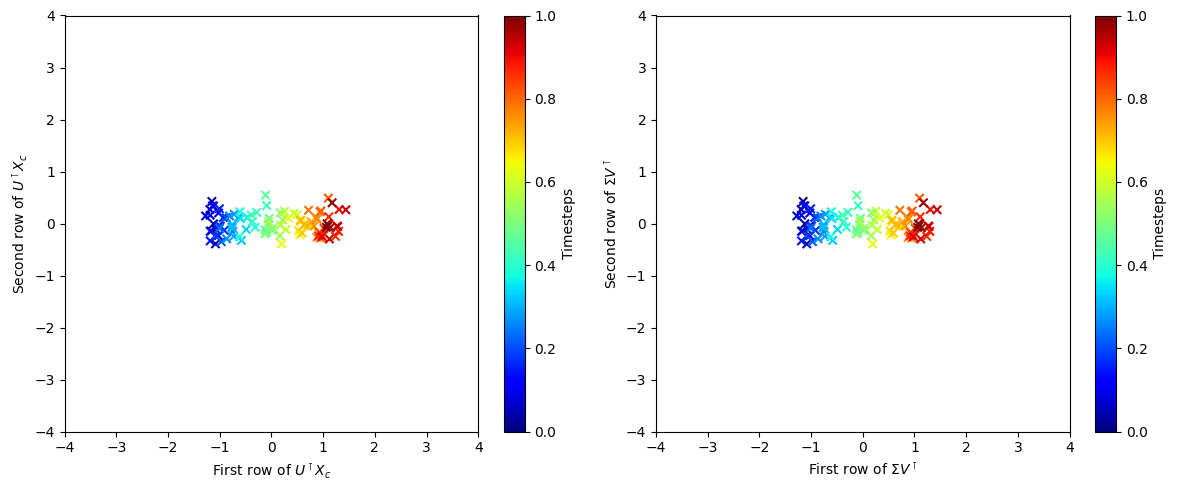

In [32]:

color_values = np.linspace(0, 1, num=nb_timesteps)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First plot: U.T @ X_centered
scatter1 = axes[0].scatter(data_UT_X_centered[0], data_UT_X_centered[1],
                           marker='x', cmap='jet', c=color_values)
axes[0].set_ylim(-4, 4)
axes[0].set_xlim(-4, 4)
axes[0].set_xlabel('First row of $U^\\intercal X_c$')
axes[0].set_ylabel('Second row of $U^\\intercal X_c$')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Timesteps')

# Second plot: np.diag(S) @ Vh
scatter2 = axes[1].scatter(data_S_Vh[0], data_S_Vh[1],
                           marker='x', cmap='jet', c=color_values)
axes[1].set_ylim(-4, 4)
axes[1].set_xlim(-4, 4)
axes[1].set_xlabel('First row of $\\Sigma V^\\intercal$')
axes[1].set_ylabel('Second row of $\\Sigma V^\\intercal$')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Timesteps')

# Adjust layout
plt.tight_layout()
plt.show()

explain what you see:

the first and seocnd rows of U.T X and Σ V.T are the exact same! This makes sense as by definition :

X = U Σ .VT , changing the U to the other side:

U.T X = Σ V.T








## Performing PCA on neural data


# Exercice 2


In [33]:
def gaussian(x, sigma, mu=0):
    return np.exp(-((x-mu)**2) / (2*sigma**2))

def make_conv_kernel( sigma= 30):
    nb_time_frames = 6*sigma
    conv_kernel = gaussian(np.arange(-nb_time_frames//2,nb_time_frames//2,1), sigma=sigma)
    conv_kernel /= np.sum(conv_kernel)

    return conv_kernel

def smoothen_data(dic, sigma=30):
    # Get number of neurons
    nb_neurons = len(dic['mat'])

    # Create the convolution kernel
    conv_kernel = make_conv_kernel(sigma=sigma)

    # Pre-allocate the smooth_mat with the same structure as dic['mat']
    smooth_mat = [None] * nb_neurons

    # Loop over neurons, but vectorize across trials
    for neuron in range(nb_neurons):
        # Get all trials for this neuron as a 2D matrix (nb_trials, time_points)
        mat_neuron = dic['mat'][neuron]

        # Use fftconvolve for faster convolution across all trials
        smooth_neuron = fftconvolve(mat_neuron, conv_kernel[None, :], mode='same', axes=1)

        # Store the result back
        smooth_mat[neuron] = smooth_neuron

    # Replace the original matrix with the smoothed data
    dic['sm_mat'] = smooth_mat
    return dic


def raster_plot(neural_data, label):
  # Create the raster plot using Plotly
  fig = go.Figure(data=go.Heatmap(
      z=neural_data,
      colorscale='Greys',
      colorbar=dict(
          title="Neural Activity",
          titleside='right',
          ticks='outside',
          ticklen=5,
          tickcolor='black',
      )
  ))


    # Add annotation if label is provided
  if label is not None:
    fig.add_annotation(
        text=label,
        xref="paper", yref="paper",
        x=0.05, y=0.95,  # Adjust position as needed
        showarrow=False,
        font=dict(size=32, color="blue"),
    )

  fig.update_layout(
      title="Neural Activity Raster Plot",
      xaxis=dict(
          title="Time (ms)",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      yaxis=dict(
          title="Trial Index",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      plot_bgcolor='white',
      font=dict(size=14),
  )

  # Display the plot
  fig.show()
  return()

The cell below stores the data in the dictionnary dic_cont8. The raw data is stored in dic_cont8['mat'] which is a list of size 777, that is the total number of neurons. Each element of this list contains a matrix of size (#trials x #timesteps). For each recording, that is for each trial, the data is shifted so that the 'GO' signal always shows up at the 2000th time frame.

In [34]:
# Load the data from the .npy files

centering = 'GO'
dic_cont8 =np.load('MathTools_TD2/dic_cont8_GO.npy', allow_pickle = True).flat[0]
# Smooth the data using a Gaussian filter with a sigma of 100
dic_cont8 = smoothen_data(dic_cont8, sigma=100)

nb_neurons = len(dic_cont8['target'])

nb_trials_cont8 = np.zeros(nb_neurons)
for i in range(nb_neurons):
    nb_trials_cont8[i] = dic_cont8['target'][i].shape[0]


##1) answer

Binary data is not ideal because a spike is usually not alone if it's significant (spike-trains rather...) and conversely noise can also be passed on a spike. So instead smoothing over data to get time/spike-averages captures the true signal.

Indeed, PCA relies on covariance, which is much better calculated from continuous values that take this spike averages.
Less true covariance if there are only 2 possible values at a singular time point!

## 2)

In [35]:
neural_data_smooth = dic_cont8['sm_mat'][0]  # Shape: (271, 4001)


neural_data_smooth_c_1 = []
neural_data_smooth_c_2 = []
neural_data_smooth_c_3 = []
neural_data_smooth_c_4 = []
neural_data_smooth_c_5 = []
neural_data_smooth_c_6 = []
neural_data_smooth_c_7 = []
neural_data_smooth_c_8 = []


for i in range(neural_data_smooth.shape[0]):
  cue_number = dic_cont8['target'][0][i]

  ### if target is 1
  if cue_number == 1:
    neural_data_smooth_c_1.append(neural_data_smooth[i])
  if cue_number == 2:
    neural_data_smooth_c_2.append(neural_data_smooth[i])
  if cue_number == 3:
    neural_data_smooth_c_3.append(neural_data_smooth[i])
  if cue_number == 4:
    neural_data_smooth_c_4.append(neural_data_smooth[i])
  if cue_number == 5:
    neural_data_smooth_c_5.append(neural_data_smooth[i])
  if cue_number == 6:
    neural_data_smooth_c_6.append(neural_data_smooth[i])
  if cue_number == 7:
    neural_data_smooth_c_7.append(neural_data_smooth[i])
  if cue_number == 8:
    neural_data_smooth_c_8.append(neural_data_smooth[i])



raster_plot(neural_data_smooth_c_1, label="1")
raster_plot(neural_data_smooth_c_2, label="2")
raster_plot(neural_data_smooth_c_3, label="3")
raster_plot(neural_data_smooth_c_4, label="4")
raster_plot(neural_data_smooth_c_5, label="5")
raster_plot(neural_data_smooth_c_6, label="6")
raster_plot(neural_data_smooth_c_7, label="7")
raster_plot(neural_data_smooth_c_8, label="8")

Output hidden; open in https://colab.research.google.com to view.

##3)

In [36]:

nb_trials = np.zeros(nb_neurons)
for i in range(nb_neurons):
    nb_trials[i] = dic_cont8['target'][i].shape[0]


##4)


In [37]:
nb_neurons= len(dic_cont8['mat'])
nb_trials_per_c = np.zeros((8,nb_neurons))

for i in range(nb_neurons):
  for j in range(int(nb_trials[i])):
    nb_trials_per_c[dic_cont8['target'][i][j]-1,i] += 1


In [38]:
colors = np.array([(85, 107, 194), (0, 182, 212), (74, 205, 152),(115, 169, 8), (245, 185, 0), (244, 120, 0), (223, 47, 47), (194, 85, 161)]) # ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray']


for target in range(8):

  mean_value = np.mean(nb_trials_per_c[target])

  # Create a histogram with Plotly
  fig = go.Figure()

  # Add the histogram
  fig.add_trace(go.Histogram(
      x=nb_trials_per_c[target],
      nbinsx=50,  # Adjust the number of bins to suit the distribution
      marker_color=plotly.colors.label_rgb(colors[target]),
      opacity=0.75,
      histnorm='probability',  # Normalized to show probability density
      name = 'target %s'%(target+1)
  ))

      # Add a vertical line at the mean value
  fig.add_trace(go.Scatter(
        x=[mean_value, mean_value],
        y=[0, 0.1],  # This extends the line from the bottom to the top of the plot
        mode="lines",
        line=dict(color="red", width=2, dash="dash"),  # Customize line appearance
        name="Mean",
        showlegend = True
  ))

  # Customize the layout for a clean, publication-quality appearance
  fig.update_layout(
      title="Distribution of nb_trials",
      xaxis=dict(
          title="Number of trials",
          showgrid=True,
          gridcolor='rgba(230,230,230,0.5)',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True,
          ticks='outside'
      ),
      yaxis=dict(
          title="Density",
          showgrid=True,
          gridcolor='rgba(230,230,230,0.5)',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True,
          ticks='outside'
      ),
      font=dict(size=16),
      plot_bgcolor='white',
      paper_bgcolor='white',
      showlegend=True,
      width = 800,
      height = 600
  )

  # Update the color of the bins for a more refined palette
  fig.update_traces(marker_line_color='black',  # Bin border color
                    marker_line_width=1.5)     # Bin border width

  # Show the plot
  fig.show()

##5)


In [39]:
X = []

nb_trials_more_than_100 =[x >= 100 for x in nb_trials]

for i in range(nb_neurons):
  if nb_trials_more_than_100[i]:

    X.append((dic_cont8['sm_mat'][i][:100]).flatten())
    ### align all 4001 time steps a 100 times so timesteps trial 1, timesteps trial 2,..... 100
X = np.array(X)
np.shape(X)

(652, 400100)

##6)

In [40]:
X_centered = X - X.mean(axis=1)[:,None] #do we have to center the data?

C = (X_centered@X_centered.T)/400100
eigval, eigvec = np.linalg.eigh(C)


In [41]:
PC1 = eigvec[:,-1]
PC2 = eigvec[:,-2]
PC3 = eigvec[:,-3]


It's hard to tell anything from this plot. One thing we could do is color code the plot by having a different color for each time bin

In [42]:
times = np.zeros(4001*100)
for trial in range(100):
  times[4001*trial:(trial+1)*4001] = np.linspace(0,1, 4001)
times.shape

(400100,)

In [43]:
import plotly.graph_objects as go

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(PC1 @ X)[::100],
    y=(PC2 @ X)[::100],
    z=(PC3 @ X)[::100],
    mode='markers',
    marker=dict(size = 4,
                  colorscale = 'Agsunset',
                  color = times[::100],
                  colorbar = dict(title ='Time',
                                  titleside = 'top',
                                  tickvals = [0,1],
                                  ticktext=['Early','Late'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()



## 6) Question: what can you tell from this plot ? What source of variance does this PCA seem to capture ?  answer:

We do not capture the variance through cued targets, but rather the variance through time, and the inter-trial variance (the variance between trials).


In fact, our first two principal components seem to capture the variance in neural activity that's related to the time in the trial.




##7) answer: 562 neurons

In [44]:
neuron_filter_ct = np.zeros(nb_neurons) == 0
# 12 trials for each of the 8 cued targets  [x >= 12 for x in trials_per]

for iii in range(8):
  for i in range(nb_neurons):
    count = 0
    for ii in range(len(dic_cont8['target'][i][:])):
        if (dic_cont8['target'][i][ii] == iii +1):
          count += 1
    if count >= 12:
        continue

    else:
        neuron_filter_ct[i] = False

#print(neuron_filter_ct)


nb_valid_neurons= neuron_filter_ct * 1
print(np.sum(nb_valid_neurons))

562


##8)


In [45]:
X_targ = []
temp = []
### take only ones who are valid

for i in range(nb_neurons):

  for iii in range(8):
    count=0
    if nb_valid_neurons[i] == 1:
      for ii in range(len(dic_cont8['target'][i][:])):
        if count <12 and (dic_cont8['target'][i][ii] == iii +1):

            temp = np.concatenate((temp,dic_cont8['sm_mat'][i][ii]))
            count += 1

  if len(temp) > 0 :
    X_targ.append(temp)
  temp = []

X_targ = np.array(X_targ)
print(np.shape(X_targ))

(562, 384096)


##9)


In [46]:
# X_targ_centered = X_targ - X_targ.mean(axis=1)[:,None]

C = (X_targ@X_targ.T)/(8*12*4001)

eigval_targ, eigvec_targ = np.linalg.eigh(C)

Let's plot the explained variance

In [47]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=np.arange(1,11),  # Component numbers
    y=np.cumsum(eigval_targ[::-1] / eigval_targ.sum())[:10],
    mode='lines+markers',
    marker=dict(size=8, color='blue'),
    line=dict(color='royalblue', width=2),
    name="Cumulative Explained Variance"
))

# Customize layout for publication-quality appearance
fig.update_layout(
    title="Cumulative Explained Variance by the 10 first Principal Components",
    xaxis_title="Number of Principal Components",
    yaxis_title="Cumulative Explained Variance",
    xaxis=dict(
        tickmode='linear',
        tick0=1,
        dtick=1,
        showgrid=True,
        gridcolor='lightgrey',
        linecolor='black',
        mirror=True
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey',
        linecolor='black',
        mirror=True,
        range=[0, 1.05],  # Set range slightly above 1 for clarity
        tickformat=".0%"
    ),
    font=dict(family="Times New Roman, serif", size=12, color="black"),
    plot_bgcolor="white",
    margin=dict(l=60, r=40, t=60, b=60),
)

# Show the plot
fig.show()


In [48]:
times = np.zeros(4001*12*8)
for trial in range(12*8):
  times[4001*trial:(trial+1)*4001] = np.linspace(0,1, 4001)
times.shape

(384096,)

In [49]:
import plotly.graph_objects as go

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec_targ[:,-1] @ X_targ)[::100],
    y=(eigvec_targ[:,-2]  @ X_targ)[::100],
    z=(eigvec_targ[:,-3]  @ X_targ)[::100],
    mode='markers',
    marker=dict(size = 4,
                  colorscale = 'Agsunset',
                  color = times[::100],
                  colorbar = dict(title ='Time',
                                  titleside = 'top',
                                  tickvals = [0,1],
                                  ticktext=['Early','Late'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


### We will now change the colorcode to reflect the cued targets

In [50]:
colors = np.zeros(4001*12*8)
for target in range(8):
  colors[4001*12*target:(target+1)*4001*12] = target/7

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec_targ[:,-1] @ X_targ)[::100],
    y=(eigvec_targ[:,-2]  @ X_targ)[::100],
    z=(eigvec_targ[:,-3]  @ X_targ)[::100],
    mode='markers',
    marker=dict(size = 4,
                  colorscale = 'Rainbow',
                  color = colors[::100],
                  colorbar = dict(title ='Target',
                                  titleside = 'top',
                                  tickvals = np.linspace(0,1,8),
                                  ticktext=['1','2','3','4','5','6','7','8'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


##9) Question:  What source of variance is now being captured by the covariance matrix which was not captured before ? answer:


The PCA plot is now seemingly much more 2-dimensional compared to the previous strongly 3D plot.

**We are now capturing the variance through cued targets**, as well as the variance through time


---
## 10) Why does averaging over the trials would reduce the inter-trial variance ?  asnwer:

The Law of Large Numbers cancels out noise to reveal only true signal. Indeed, since noise is random it would average out over N trials if N --> inf.

Since you reduce the noise of the trials, you reduce the  variance between the trials, the only variance left is that of the signal which we really want to capture.


Previously a large part of the variance came from inter-trial noise, which is now reduced.

---



## 11)


In [51]:
X_s = []


temp = []
average_over_trials_per_cue = []
for i in range(nb_neurons):

  average_over_trials_per_cue = []

  for iii in range(8):
    count=0
    temp = []

    if nb_valid_neurons[i] == 1:
      for ii in range(len(dic_cont8['target'][i][:])):
        if count <12 and (dic_cont8['target'][i][ii] == iii +1):

            temp.append((dic_cont8['sm_mat'][i][ii][1950:2000]))

            count += 1

    if len(temp) > 0 :
      temp = np.mean(temp, axis=0)
      average_over_trials_per_cue = np.concatenate((average_over_trials_per_cue, temp))

  if len(temp) > 0 :
    X_s.append(average_over_trials_per_cue)

X_s = np.array(X_s)
print(np.shape(X_s))

(562, 400)


In [52]:
C = (X_s@X_s.T)/(50*8)

eigval_s, eigvec_s =  np.linalg.eigh(C)


In [53]:
#SUJET (faux!!!!)
colors = np.zeros(400*8)
for target in range(8):
  colors[400*target:(target+1)*400] = target/7
colors.shape

#MY TEST
colors = np.zeros(50*8)
for target in range(8):
  colors[50*target:(target+1)*50] = target/7
colors.shape



(400,)

In [54]:

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec_s[:,-1]  @ X_s),
    y=(eigvec_s[:,-2]  @ X_s),
    z=(eigvec_s[:,-3]  @ X_s),
    mode='markers',
    marker=dict(size = 4,
                  colorscale = 'Rainbow',
                  color = colors,
                  colorbar = dict(title ='Target',
                                  titleside = 'top',
                                  tickvals = np.linspace(0,1,8),
                                  ticktext=['1','2','3','4','5','6','7','8'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


## 11) answer:

In this plot, the trajectories of the averaged over trials of the 8 cues are small (because we only look at 50ms) and **the cues are distinctly separated in space. This means the PCs allow to distinguish between the different cues.**

However the PCs don't allow to distinguish between the trials, as they have been averaged out.

##12)

In [55]:
X_st = []
temp = []
### take only ones who are valid

for i in range(nb_neurons):

  for iii in range(8):
    count=0
    if nb_valid_neurons[i] == 1:
      for ii in range(len(dic_cont8['target'][i][:])):
        if count <12 and (dic_cont8['target'][i][ii] == iii +1):

            temp = np.concatenate((temp,dic_cont8['sm_mat'][i][ii][1950:2000]))
            count += 1

  if len(temp) > 0 :
    X_st.append(temp)
  temp = []

X_st = np.array(X_st)
print(np.shape(X_st))



C = (X_st@X_st.T)/(50*12*8)
eigval_st, eigvec_st = np.linalg.eigh(C)

(562, 4800)


In [56]:

colors = np.zeros(50*12*8)
for target in range(8):
  colors[50*12*target:(target+1)*50*12] = target/7



fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec_s[:,-1]  @ X_st),
    y=(eigvec_s[:,-2]  @ X_st),
    z=(eigvec_s[:,-3]  @ X_st),
    mode='markers',
    marker=dict(size = 4,
                  colorscale = 'Rainbow',
                  color = colors,
                  colorbar = dict(title ='Target',
                                  titleside = 'top',
                                  tickvals = np.linspace(0,1,8),
                                  ticktext=['1','2','3','4','5','6','7','8'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


## 12) answer:

In this plot we see 12 trajectories per each target cues. This is logical because we didn't average over trials.

The trajectories are still short bcs of 50ms. But the cues' space is now separable by clustering. We clearly see that each target cue  occupies a distinct neural space.

The clusters are also consistent because for each cue, the 12 trajectories are heading in the same direction.

##13)

In [57]:
X_st = []
temp = []

for i in range(nb_neurons):

  for iii in range(8):
    count=0
    if nb_valid_neurons[i] == 1:
      for ii in range(len(dic_cont8['target'][i][:])):
        if count <12 and (dic_cont8['target'][i][ii] == iii +1):

            temp = np.concatenate((temp,dic_cont8['sm_mat'][i][ii][1000:3000]))
            count += 1

  if len(temp) > 0 :
    X_st.append(temp)
  temp = []

X_st = np.array(X_st)
print(np.shape(X_st))

C = (X_st@X_st.T)/(2000*12*8)
eigval_st, eigvec_st = np.linalg.eigh(C)

(562, 192000)


In [58]:
colors = np.zeros(2000*12*8)
for target in range(8):
  colors[2000*12*target:(target+1)*2000*12] = target/7



fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec_s[:,-1]  @ X_st),
    y=(eigvec_s[:,-2]  @ X_st),
    z=(eigvec_s[:,-3]  @ X_st),
    mode='markers',
    marker=dict(size = 4,
                  colorscale = 'Rainbow',
                  color = colors,
                  colorbar = dict(title ='Target',
                                  titleside = 'top',
                                  tickvals = np.linspace(0,1,8),
                                  ticktext=['1','2','3','4','5','6','7','8'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()



Output hidden; open in https://colab.research.google.com to view.

## 14) answer:

To improve the data representation, a valuable adjustment would be to **normalize the data across neurons** to account for variations in their intrinsic firing rate variability. This would make the PCA results better suited to capturing the underlying structure of the data related to the cues.

Neurons often exhibit differing levels of firing rate variability, which can cause an **imbalance in their contributions to the analysis.**

A practical approach would involve trial-averaging within a defined window of interest (as already implemented) **and then normalizing the averaged firing rates for each neuron.** This could be done **by applying z-scoring** (subtracting the mean and dividing by the standard deviation) on the neuron's firing rate. Such normalization ensures that all neurons are placed on the same scale.

This process allows PCA to focus on uncovering genuine patterns in neural activity rather than being skewed by differences in firing rate variability across neurons.